In [59]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.datasets.constant import IMAGE_TYPE
from scripts.datasets.preprocess_raw import FLARE22_Preprocess
from scripts.utils import torch_try_load

import os
from segment_anything.build_sam import sam_model_registry
from scripts.experiments.mask_aug.inference import class_inference, load_model
from scripts.sam_train import SamTrain
from segment_anything.modeling.sam import Sam
from scripts.datasets.constant import FLARE22_LABEL_ENUM
%matplotlib inline

TRAIN_ROOT = "../dataset/FLARE22-version1/FLARE22_LabeledCase50"
TRAIN_IMAGE_PATH = os.path.join(TRAIN_ROOT, "images/*.nii.gz")
TRAIN_MASK_PATH = os.path.join(TRAIN_ROOT, "labels/*.nii.gz")

VAL_ROOT = "../dataset/FLARE22-version1/ReleaseValGT-20cases"
VAL_IMAGE_PATH = os.path.join(VAL_ROOT, "images/*.nii.gz")
VAL_MASK_PATH = os.path.join(VAL_ROOT, "labels/*.nii.gz")

train_images = sorted(list(glob(TRAIN_IMAGE_PATH)))
train_masks = sorted(list(glob(TRAIN_MASK_PATH)))
train_file = list(zip(train_images, train_masks))

val_images = sorted(list(glob(VAL_IMAGE_PATH)))
val_masks = sorted(list(glob(VAL_MASK_PATH)))
val_file = list(zip(val_images, val_masks))

val_remove = [f"00{sym}_0000" for sym in ["06","08","21","31","33","36","38","43","44","48"]]
val_file = [f for f in val_file if len(list(filter(lambda x: x in f[0], val_remove))) == 0]

# MODEL_PATH = "../runs/transfer/imp-230603-150046/model-20.pt"
MODEL_PATH = "../runs/exps-230701-165310/model-20.pt"

def make_model() -> SamTrain:
    model: Sam = sam_model_registry["vit_b"](
            checkpoint="../sam_vit_b_01ec64.pth", custom=MODEL_PATH
        )
    sam_train = SamTrain(sam_model=model)
    return sam_train


10


In [ ]:
# Statistic
# Global Organ Centroid
# Local-Organ Centroid
# Area, area ratio between middle frame to the index by cohort of time-axis
# -> have to check the consistency between train-test set

In [78]:
from typing import Tuple
from scripts.experiments.mask_aug.inference import get_all_organ_range


preprocessor = FLARE22_Preprocess()

def centroid_of_volume(mask_volume: np.ndarray, class_number: int):
    coors = np.argwhere(mask_volume == class_number)
    centroid = np.mean(coors, axis=0)
    centroid_percent = centroid / mask_volume.shape
    centroid = np.ceil(centroid)
    return centroid, centroid_percent

def global_centroid(mask_volume: np.ndarray) -> np.ndarray:
    # padding for back-ground
    result = [[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]]]
    
    for target_organ in range (1, 14):
        cent, cent_per = centroid_of_volume(mask_volume, target_organ)
        result[0].append(cent)
        result[1].append(cent_per)

    return np.array(result)

def local_coordinate_centroid(mask_volume: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    starts, ends = get_all_organ_range(mask_volume)
    # centroids, centroid_percents = [0], [0.0]
    result = [[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]]]
    for organ_num in range(1, 14):
        organ_volume = (
            mask_volume[starts[organ_num]:ends[organ_num] + 1] == organ_num).astype(np.uint16
        )
        # as converted  -> class number will be == 1 as for True
        centroid, centroid_percent = centroid_of_volume(mask_volume=organ_volume, class_number=1)
        result[0].append(centroid)
        result[1].append(centroid_percent)
        pass
    
    return np.array(result), starts, ends

def centroid_by_path(image_file, gt_file, is_reversed=True):
    volumes, masks = preprocessor.run_with_config(
        image_file=image_file,
        gt_file=gt_file,
        config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
    )
    if is_reversed:
        volumes = volumes[::-1]
        masks = masks[::-1]

    global_cents = global_centroid(masks)
    local_cents, starts, ends = local_coordinate_centroid(masks)
    result = {
        'global_centroids': global_cents,
        'local_centroids': local_cents,
        'starts': starts,
        'ends': ends,
        'z-axis': masks.shape[0],
    }
    return result

entries = centroid_by_path(image_file=train_file[0][0], gt_file=train_file[0][1])


In [79]:
entries['z-axis']

110

In [80]:
# Aggregate centroid feature and compare with test set
def mean_centroid(files):
    entries = {}
    entries["global_centroids"] = []
    entries["local_centroids"] = []
    entries["starts"] = []
    entries["ends"] = []
    entries["z-axis"] = []
    
    for image_file, gt_file in files:
        features = centroid_by_path(image_file=image_file, gt_file=gt_file, is_reversed=True)
        entries["global_centroids"].append(features['global_centroids'])
        entries["local_centroids"].append(features['local_centroids'])
        entries["starts"].append(features['starts'])
        entries["ends"].append(features['ends'])
        entries["z-axis"].append(features['z-axis'])
        pass
    
    result = {}
    result["global_centroids"] = np.transpose(np.stack(entries["global_centroids"]), [1, 2, 0, 3]).mean(axis=-2)
    result["local_centroids"] = np.transpose(np.stack(entries["local_centroids"]), [1, 2, 0, 3]).mean(axis=-2)
    result['z-axis'] = np.mean(entries['z-axis'])
    result['starts'] = np.mean(np.stack(entries['starts']), axis=0)
    result['ends'] = np.mean(np.stack(entries['ends']), axis=0)

    return result, entries

train_result, train_entries = mean_centroid(train_file[:])
val_result, val_entries = mean_centroid(val_file[:]) 

In [81]:
print("=" *20)
print(train_result['global_centroids'][1][1])
print(train_result['local_centroids'][1][1])
print(train_result['starts'][1])
print(train_result['ends'][1])
print(train_result['z-axis'])
print("=" *20)
print(val_result['global_centroids'][1][1])
print(val_result['local_centroids'][1][1])
print(val_result['starts'][1])
print(val_result['ends'][1])
print(val_result['z-axis'])

[0.35235539 0.54490201 0.67218827]
[0.38626369 0.54490201 0.67218827]
8.98
72.04
95.88
[0.31946057 0.52766557 0.64555469]
[0.40126206 0.52766557 0.64555469]
17.1
84.2
145.9


In [83]:
local_mean_centroid = train_result['local_centroids'][1]
print(local_mean_centroid)

[[0.         0.         0.        ]
 [0.38626369 0.54490201 0.67218827]
 [0.48156498 0.41671609 0.67028918]
 [0.4553384  0.40754253 0.25859889]
 [0.42140162 0.55588311 0.47004136]
 [0.42468646 0.45536068 0.47502494]
 [0.46189611 0.49859286 0.55371147]
 [0.41459959 0.44073697 0.58463228]
 [0.43845326 0.46663026 0.40780831]
 [0.46969292 0.61471249 0.6829716 ]
 [0.55895977 0.48290006 0.47029219]
 [0.43797963 0.60988944 0.40558907]
 [0.50134942 0.54969613 0.5321504 ]
 [0.47531588 0.41609956 0.31968864]]


In [106]:
def test_centroid(files, local_mean_centroid: np.ndarray, is_reversed=True):
    proposal_centroids = []
    preds = []
    for image_file, gt_file in files:
        _, masks = preprocessor.run_with_config(image_file, gt_file, IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER)
        if is_reversed: masks = masks[::-1]
        starts, ends = get_all_organ_range(masks)
        dur = ends - starts
        dur: np.ndarray = np.pad(np.reshape(dur, [-1, 1]), pad_width=[(0, 0), (0, 2)], constant_values=512)
        # Take the centroid in z-axis of local organ, and then add back the starts
        proposal = dur * local_mean_centroid + np.pad(np.reshape(starts, [-1, 1]), pad_width=[(0, 0), (0, 2)], constant_values=0.0)
        proposal_centroids.append(proposal.copy())
        proposal = np.ceil(proposal).astype(np.uint16).tolist()
        pred = [0]
        for organ_num in range(1, 14):
            z, y, x  = proposal[organ_num]
            pred.append(masks[z, y, x])
            pass
        preds.append(pred)

    return np.array(proposal_centroids), np.array(preds)

proposal_centroids, preds = test_centroid(val_file, local_mean_centroid=local_mean_centroid)


In [107]:
preds

array([[ 0,  1,  0,  3,  0,  0,  0,  7,  0,  1,  0, 11,  0, 13],
       [ 0,  1,  0,  0,  0,  5,  0,  0,  0,  1, 11,  0,  4, 13],
       [ 0,  1,  2,  3,  5,  0,  0,  0, 13, 12, 10,  4,  0, 13],
       [ 0,  1,  2,  3,  5,  5,  0,  0,  0,  9,  0, 11,  6, 13],
       [ 0,  1,  0,  3,  0,  0,  0,  7,  0,  9,  0, 11,  0, 13],
       [ 0,  1,  0,  0,  0,  5,  0,  1,  0,  0,  0, 11,  0,  0],
       [ 0,  1,  0,  0,  0,  5,  1,  1,  4,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  5,  6,  0,  8,  0,  0, 11,  4, 13],
       [ 0,  1,  2,  3,  4,  5,  1,  1,  8,  1,  0,  1,  0, 13],
       [ 0,  1,  1, 11,  1,  1,  1,  1,  1,  0,  1,  0,  1,  4]])

In [110]:
local_mean_centroid[1]

array([0.38626369, 0.54490201, 0.67218827])

In [77]:
np.array(proposal_centroids, dtype=np.uint16)

array([[[  0,   0,   0],
        [ 22, 278, 344],
        [ 26, 213, 343],
        [ 11, 208, 132],
        [ 18, 284, 240],
        [ 37, 233, 243],
        [ 38, 255, 283],
        [  6, 225, 299],
        [  6, 238, 208],
        [  2, 314, 349],
        [ 10, 247, 240],
        [ 17, 312, 207],
        [ 17, 281, 272],
        [ 14, 213, 163]],

       [[  0,   0,   0],
        [ 23, 278, 344],
        [ 15, 213, 343],
        [ 14, 208, 132],
        [ 13, 284, 240],
        [ 42, 233, 243],
        [ 40, 255, 283],
        [  4, 225, 299],
        [  5, 238, 208],
        [  8, 314, 349],
        [ 11, 247, 240],
        [ 17, 312, 207],
        [ 21, 281, 272],
        [ 17, 213, 163]]], dtype=uint16)

In [71]:
np.pad(np.reshape(train_result['starts'], [-1, 1]), pad_width=[(0, 2)], constant_values=512)

array([[  0.  , 512.  , 512.  ],
       [  8.98, 512.  , 512.  ],
       [ 38.46, 512.  , 512.  ],
       [ 17.42, 512.  , 512.  ],
       [ 35.4 , 512.  , 512.  ],
       [  0.  , 512.  , 512.  ],
       [  9.22, 512.  , 512.  ],
       [ 29.78, 512.  , 512.  ],
       [ 33.08, 512.  , 512.  ],
       [ 42.14, 512.  , 512.  ],
       [  0.  , 512.  , 512.  ],
       [ 18.16, 512.  , 512.  ],
       [ 41.6 , 512.  , 512.  ],
       [ 37.36, 512.  , 512.  ],
       [512.  , 512.  , 512.  ],
       [512.  , 512.  , 512.  ]])

In [2]:

# preprocessor = FLARE22_Preprocess()
# volumes, masks = preprocessor.run_with_config(
#             image_file=IMAGE_PATH,
#             gt_file=MASK_PATH,
#             config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
#         )
# cache_volume = torch_try_load(VOLUME_CACHE, 'cpu')


In [ ]:
# %matplotlib widget
# from ipywidgets import widgets
# import matplotlib.pyplot as plt

# organ_idx = FLARE22_LABEL_ENUM.LIVER.value
# percent = 0.
# fig, axes = plt.subplots(1, 2)

# def f(percent):
#     idx = int((ends[1] - starts[1]) * percent) + starts[1]
#     axes[0].imshow(masks[idx])
#     axes[1].imshow(masks[idx] == 1.0)
#     axes[1].plot(274, 344, marker="o", markersize=5)
#     axes[1].set_title(f'Frame: {idx}')
#     fig.canvas.draw()
#     pass

# axes[0].imshow(masks[0])
# axes[1].imshow(masks[0] == 1.0)

# widgets.interact(f, percent=widgets.FloatSlider(min=0.0, max=1.0, step=0.02, value=0.0))

In [4]:
# As proven from another EDA, we will start to flip the mask and image for more consistent data

volumes, masks = preprocessor.run_with_config(
    image_file=IMAGE_PATH,
    gt_file=MASK_PATH,
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)

# Reversed
volumes = volumes[::-1]
masks = masks[::-1]


# centroid_by_path(IMAGE_PATH, MASK_PATH)


In [5]:
import glob

from tqdm import tqdm


TRAIN_ROOT = "../dataset/FLARE22-version1/FLARE22_LabeledCase50/"
image_list = sorted(glob.glob(f"{TRAIN_ROOT}/images/*.nii.gz"))
label_list = sorted(glob.glob(f"{TRAIN_ROOT}/labels/*.nii.gz"))

entries = []
for image_file, gt_file in tqdm(zip(image_list, label_list)):
    entries.append(centroid_by_path(image_file, gt_file))
    pass
entries = np.array(entries)


0it [00:00, ?it/s]

50it [01:18,  1.56s/it]


In [6]:
import pandas
organ_idx = 1
pandas.DataFrame(entries[:, 1, organ_idx, :]).describe()

,0,1,2
count,50.000000,50.000000,50.000000
mean,0.352355,0.544902,0.672188
std,0.058914,0.040365,0.029776
min,0.212490,0.447049,0.592080
25%,0.321103,0.521037,0.655094
50%,0.352454,0.549945,0.676175
75%,0.382750,0.566720,0.692510
max,0.490270,0.654832,0.724651


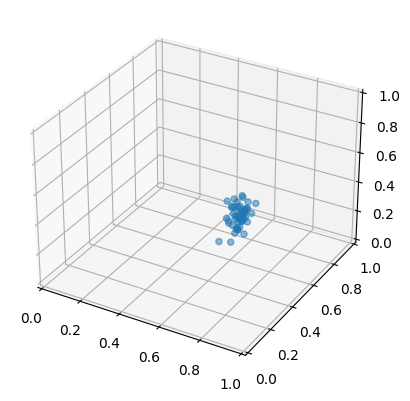

In [8]:
# sample, [coors or coors_percent], organ_idx, [x, y, z] = result.shape
from scripts.datasets.constant import FLARE22_LABEL_ENUM
organ_idx = FLARE22_LABEL_ENUM.LIVER.value
zs = entries[:, 1, organ_idx, :][:, 0]
ys = entries[:, 1, organ_idx, :][:, 1]
xs = entries[:, 1, organ_idx, :][:, 2]

mean_coordinate = np.mean(entries[:, 1, organ_idx, :], axis=0)
x_mean, y_mean, z_mean = mean_coordinate[2], mean_coordinate[1], mean_coordinate[0]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs, marker='o', alpha=0.5)
ax.scatter(x_mean, y_mean, z_mean, marker='^', s=20)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_zlim(0.0, 1.0)
plt.show()

In [10]:
x_mean, y_mean, z_mean

(0.6721882690535713, 0.5449020087665863, 0.352355387374095)

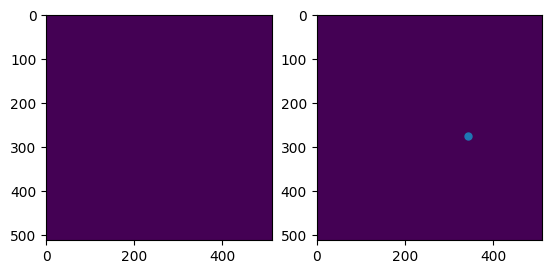

In [9]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(masks[141])
axes[1].imshow(masks[141] == 1.0)
axes[1].plot(344, 274, marker="o", markersize=5)
plt.show()

In [ ]:
def confidence_score(logits, threshold):
    # Idea: confidence is high when the prob of 
    # foreground high and prob of background is low
    foreground_score = np.mean(logits[logits >= threshold])
    background_score = 1.0 - np.mean(logits[logits < threshold])
    return np.mean([foreground_score, background_score])